In [1]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Circle
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import contextily as cx

import seaborn as sns
import os
from tqdm import tqdm

import shapely
from shapely.geometry import LineString, Point
from collections import Counter

import iteround

from sklearn.neighbors import KDTree
import importlib
from scipy.interpolate import griddata

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
tqdm.pandas(desc='My bar!')

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
import utils
importlib.reload(utils)
import plotting_utils
importlib.reload(plotting_utils)
import euler_utils
importlib.reload(euler_utils)

<module 'euler_utils' from '/cluster/home/mfrancesc/IVT/eqasim-java/switzerland/WaitTimeValidation/euler_utils.py'>

In [4]:
zurich_shp_path = '/cluster/work/ivt_vpl/mfrancesc/ScenarioBoundary/zurich_city_5km.shp'
# get lakes
lake_path = "/cluster/work/ivt_vpl/mfrancesc/lake/g1s20.shp"
zurich_districts_path = "/cluster/work/ivt_vpl/mfrancesc/city_districts/data/stzh.adm_stadtkreise_v.shp"
df_districts = plotting_utils.get_zurich_districts_gpd(zurich_districts_path)


main_folder = '/cluster/work/ivt_vpl/mfrancesc/SA_scenario/'
last_iter = 100

no_rej_4000 = euler_utils.read_output(main_folder + 'no_rejections_4000', last_iter)


100%|██████████| 101/101 [00:54<00:00,  1.85it/s]


In [5]:
it_drt_legs_gpd = utils.convert_drt_legs_to_gpd(no_rej_4000['drt_legs'][last_iter])
it_drt_trips_stats_gpd = utils.convert_drt_legs_to_gpd(no_rej_4000['drt_trips_stats'][last_iter])

# Division in time bins

In [6]:
bin_duration_min = 180 # Duration of the time bins in minutes
start_time_h = 0
end_time_h = 24

In [7]:
trips = it_drt_trips_stats_gpd.copy(deep=True)

n_bins = (end_time_h - start_time_h) * 60 // bin_duration_min
bins = [start_time_h*3600 + i*bin_duration_min*60 for i in range(0,n_bins+1)]
trips['time_bin'] = pd.cut(trips.startTime, bins).map(lambda x: str(x.left/3600) + 'h - ' + str(x.right/3600) + 'h')

In [8]:
trips.time_bin.value_counts()

15.0h - 18.0h    53599
12.0h - 15.0h    46210
9.0h - 12.0h     39070
6.0h - 9.0h      33932
18.0h - 21.0h    31052
21.0h - 24.0h    12779
3.0h - 6.0h       1453
0.0h - 3.0h        145
Name: time_bin, dtype: int64

In [9]:
def compute_avg_wait_time_for_point(trips, point, time_bin, distance_limit = 1000):
    filtered = trips.copy(deep=True)
    filtered = filtered[filtered.time_bin == time_bin]
    assert isinstance(point, Point)
    filtered['distance'] = gpd.GeoSeries(filtered.origin_geometry).distance(point)
    filtered = filtered[filtered['distance'] <= distance_limit]
    
    return filtered.waitTime.mean() / 60

In [10]:
points = utils.get_even_spaced_points_from_shapefile(zurich_shp_path, 500)

In [11]:
time_bin = trips.time_bin.cat.categories[5]
distance_limit= 1000
points['waitTime'] = points.progress_apply(lambda x: compute_avg_wait_time_for_point(trips, x.geometry,time_bin,distance_limit=distance_limit), axis=1)

My bar!: 100%|██████████| 1531/1531 [02:54<00:00,  8.79it/s]


In [12]:
points

geometry  waitTime
783   POINT (2679727.193 1237084.726)  2.040741
737   POINT (2679227.193 1237084.726)  2.376190
829   POINT (2680227.193 1237084.726)  1.433333
830   POINT (2680227.193 1237584.726)  1.433333
738   POINT (2679227.193 1237584.726)  2.421111
...                               ...       ...
1469  POINT (2686727.193 1258084.726)  4.502083
1331  POINT (2685227.193 1258084.726)  5.235606
1377  POINT (2685727.193 1258084.726)  5.875000
1332  POINT (2685227.193 1258584.726)  1.302778
1378  POINT (2685727.193 1258584.726)  2.494872

[1531 rows x 2 columns]

In [17]:
def plot_multiple_time_bins(trips, distance_limit, vmin=None, vmax=None):
    points = utils.get_even_spaced_points_from_shapefile(zurich_shp_path, 500)
    plt.figure(figsize=(20,40))
    for idx, time_bin in enumerate(trips.time_bin.cat.categories, start=1):
        copy_points = points.copy(deep=True)
        copy_points['waitTime'] = copy_points.progress_apply(lambda x: compute_avg_wait_time_for_point(trips, x.geometry,time_bin,distance_limit=distance_limit), axis=1)
        plt.subplot(4,2,idx)
        ax = plt.gca()
        copy_points.crs = "epsg:2056"
        copy_points.plot(ax=ax,column='waitTime', legend=True, markersize=20, vmin=vmin, vmax=vmax, legend_kwds={'label': "WaitTime (min)"}, cmap='plasma')
        plt.title(time_bin)
        plt.xticks([])
        plt.yticks([])
        cx.add_basemap(ax=ax, crs="epsg:2056")
    plt.show()


My bar!: 100%|██████████| 1531/1531 [01:36<00:00, 15.92it/s]


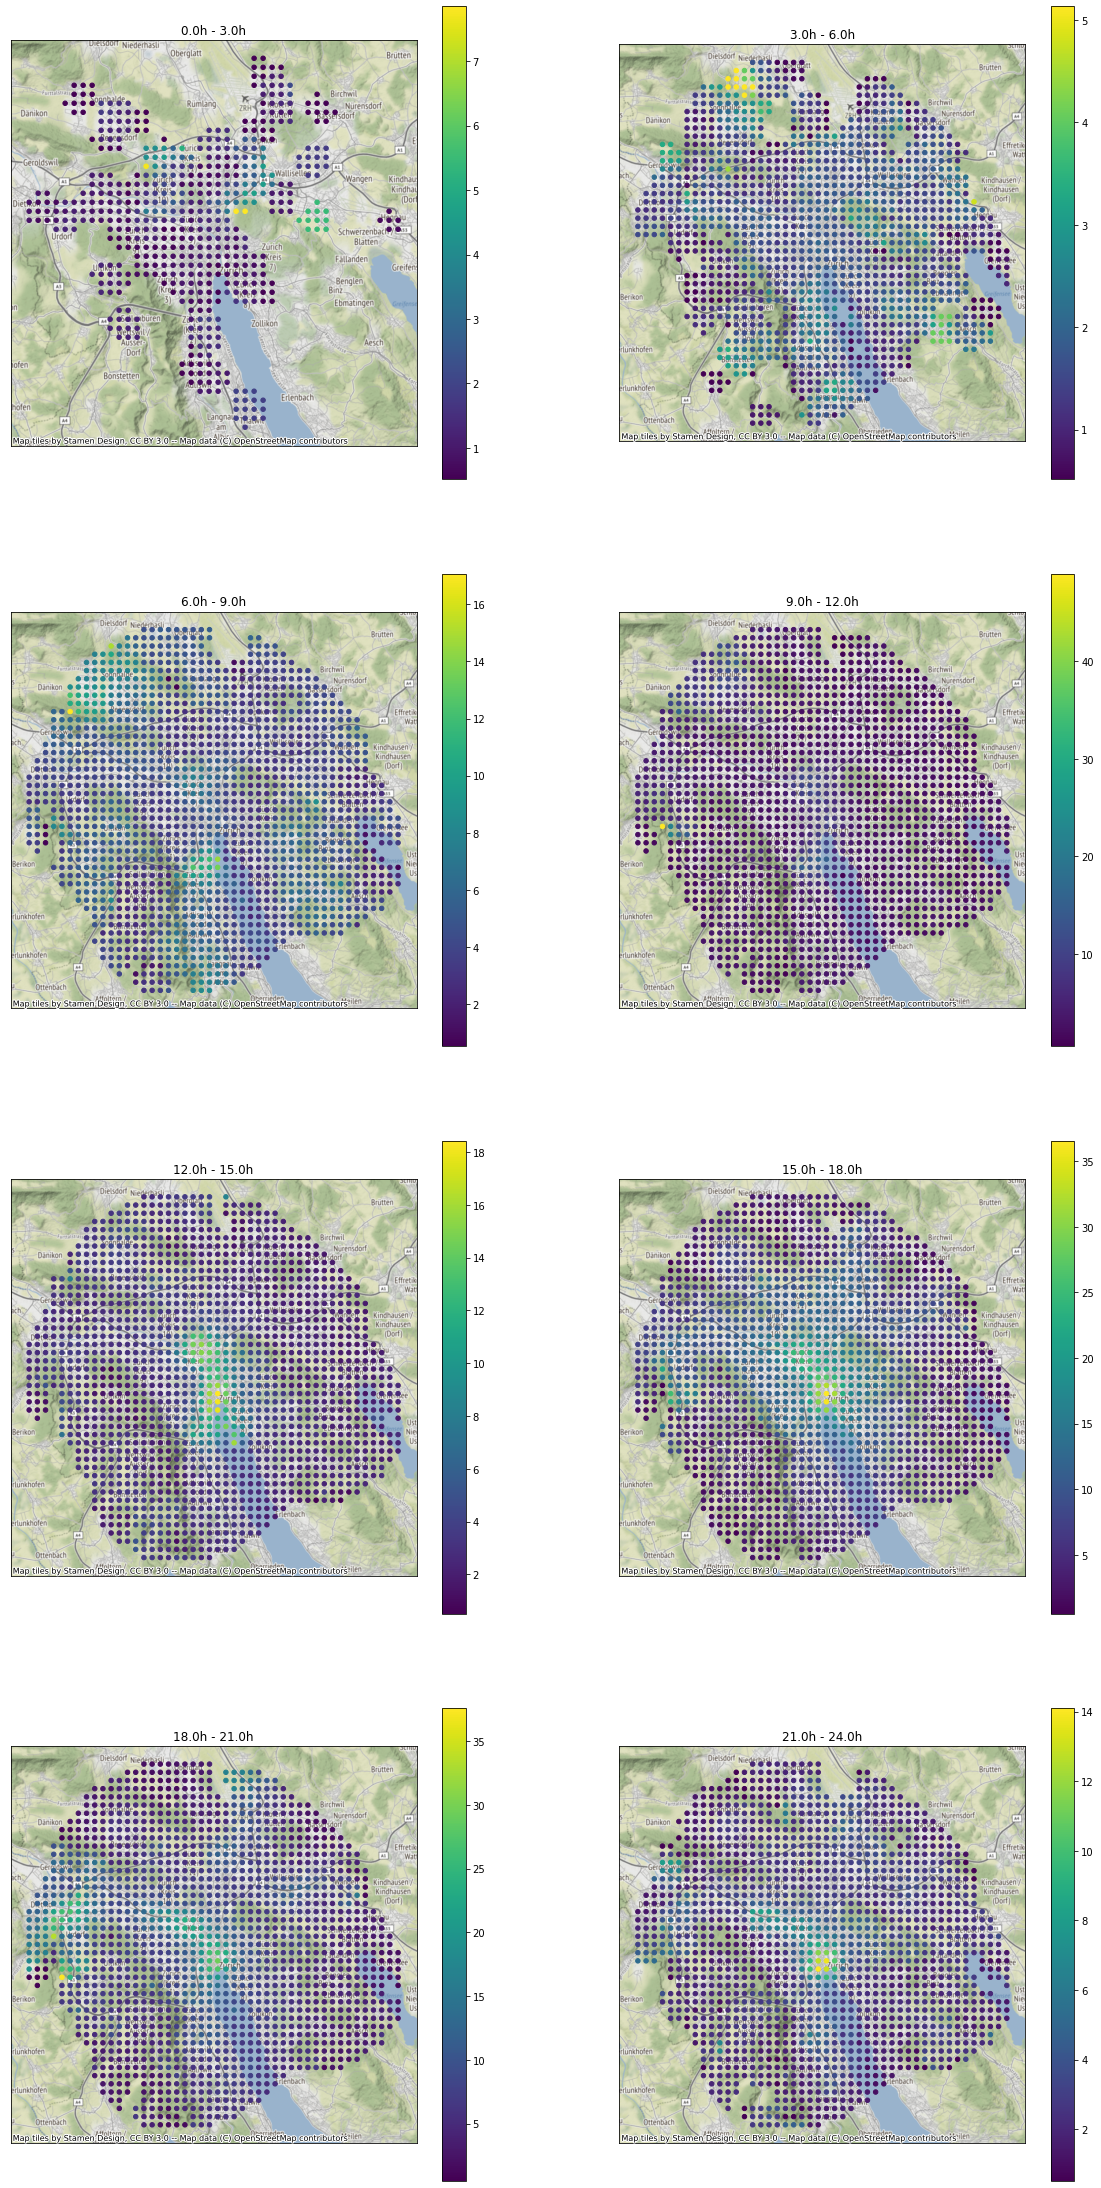

In [14]:
plot_multiple_time_bins(trips, 1000)

My bar!: 100%|██████████| 1531/1531 [01:32<00:00, 16.49it/s]


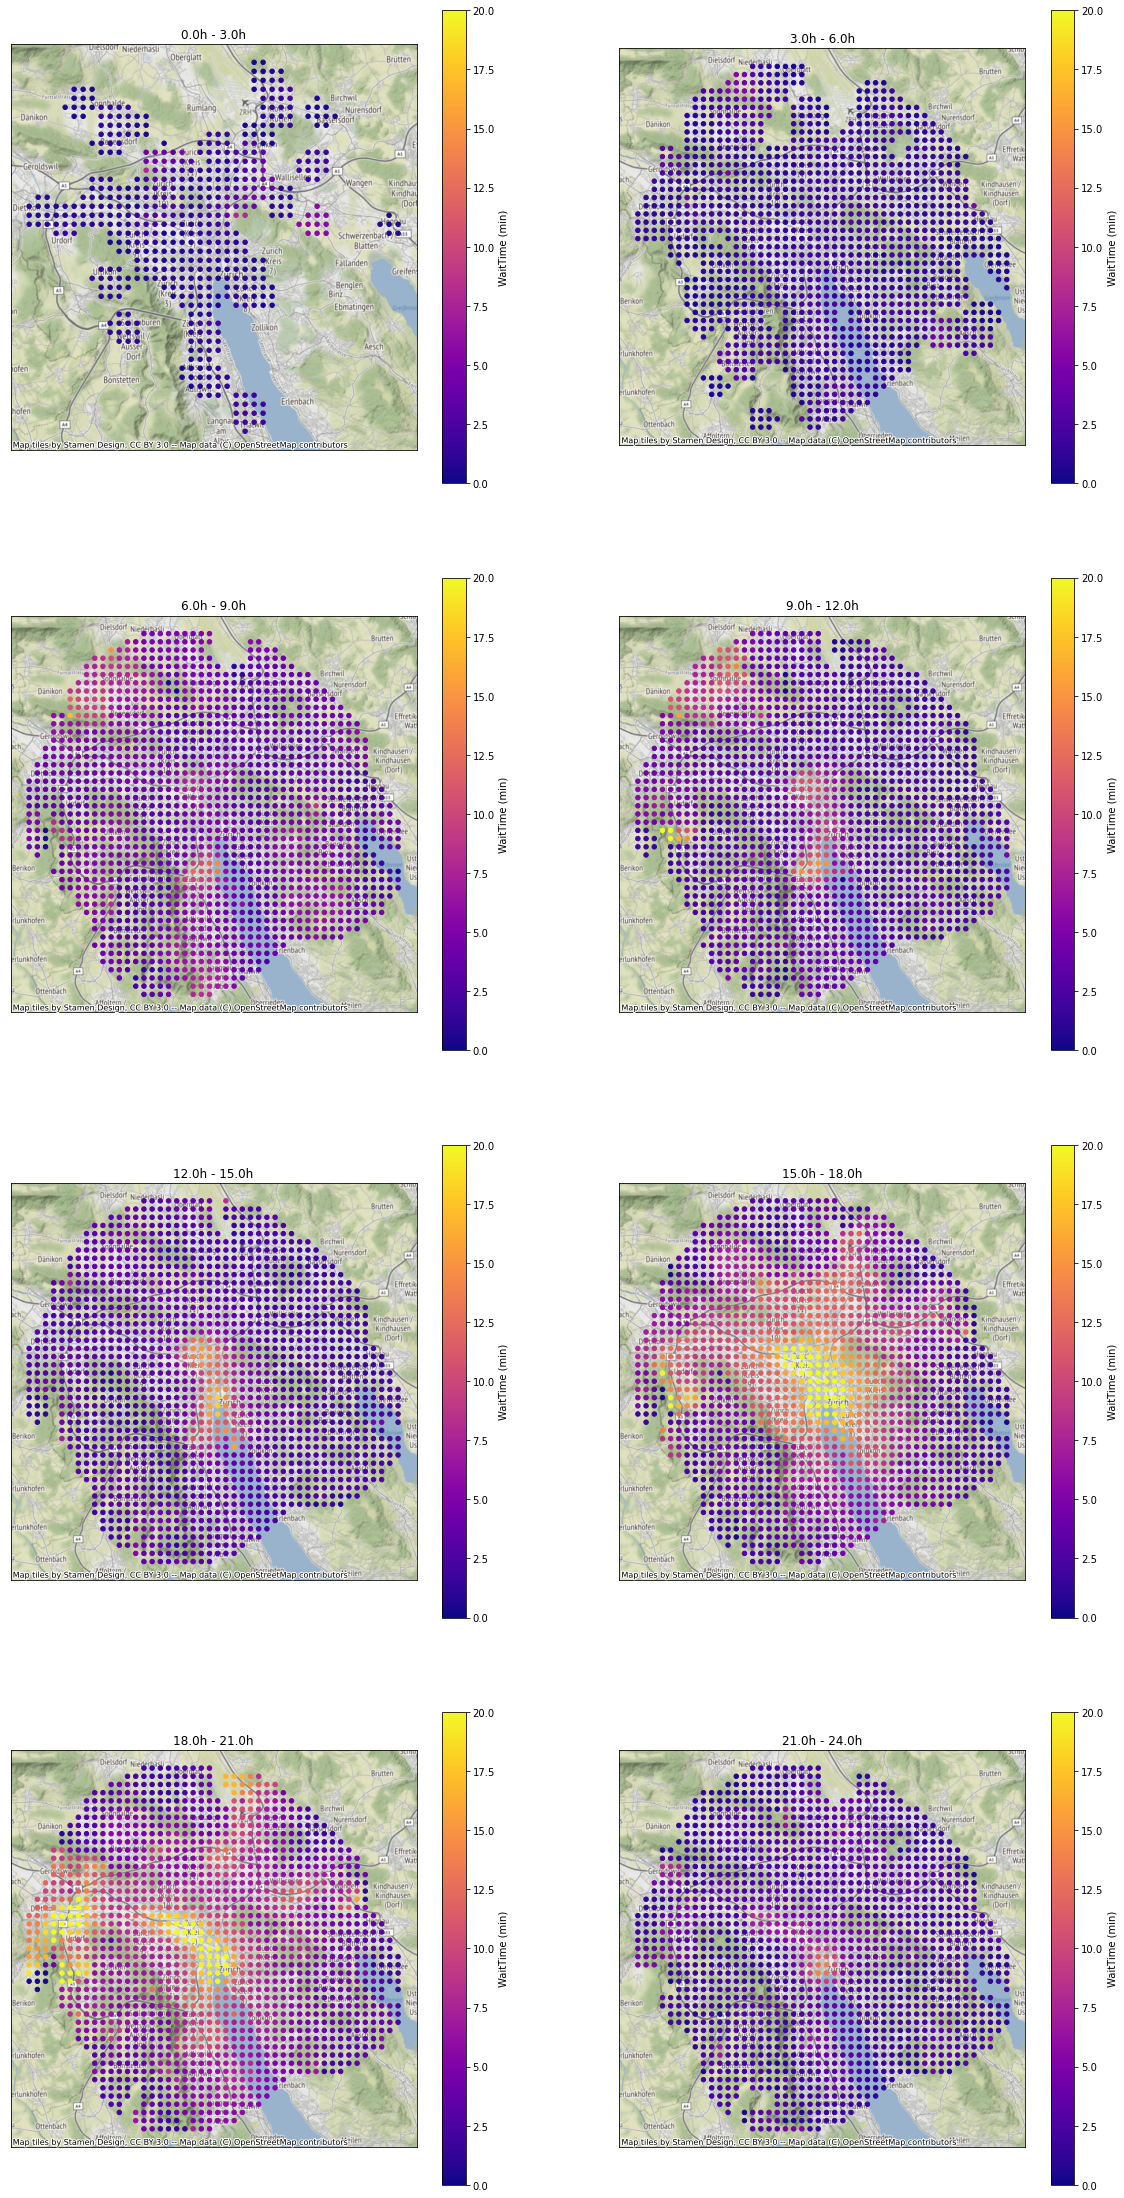

In [18]:
plot_multiple_time_bins(trips, 1000, vmin=0, vmax = 20)